# Module 4A: Bits, Pixels, and Medical Images
## From Binary Representation to Frontal vs Lateral Chest X-ray Classification

**Goal:** Understand how image information is encoded (1-bit -> 16-bit), how CT windowing works, and then build a view-classification baseline (Frontal vs Lateral) with traditional ML and a compact CNN.


### Why this module?
Before training imaging models, we need a clear mental model of:
- how pixels encode information,
- why medical images often use higher bit depth,
- and how that connects to real clinical tasks.


### Learning objectives
1. Explain how 1-bit, 2-bit, 4-bit, 8-bit, and 16-bit representations differ.
2. Visualize how more bits create more intensity levels.
3. Interpret 8-bit grayscale and 8-bit RGB pixel structures.
4. Load a 16-bit CT DICOM slice and convert raw values to Hounsfield Units (HU).
5. Apply lung and bone windowing and explain why windowing is necessary.
6. Build a frontal-vs-lateral chest X-ray classifier with a simple ML baseline.
7. Build a compact deep learning baseline for the same task.
8. Compare classical ML vs CNN in this imaging context.


## Pipeline at a Glance
`Bit depth basics -> Pixel interpretation -> DICOM + HU -> Windowing -> Dataset setup -> Traditional ML baseline -> Deep learning baseline -> Compare and reflect`


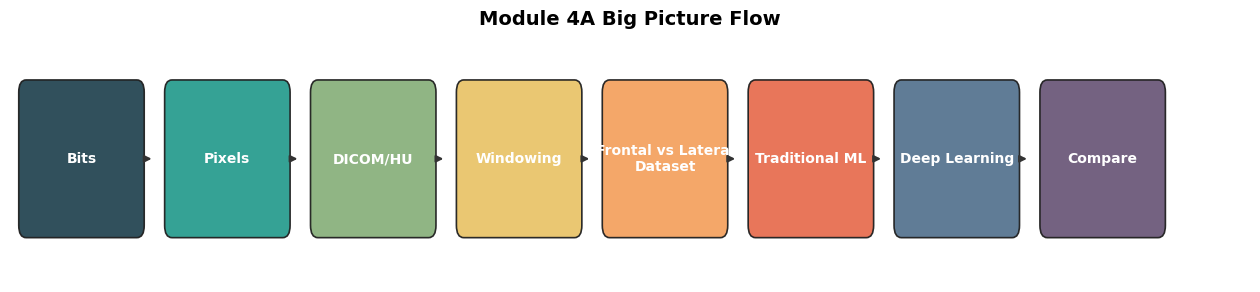

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

pipeline_steps = [
    'Bits',
    'Pixels',
    'DICOM/HU',
    'Windowing',
    'Frontal vs Lateral\nDataset',
    'Traditional ML',
    'Deep Learning',
    'Compare',
]

colors = ['#264653', '#2A9D8F', '#8AB17D', '#E9C46A', '#F4A261', '#E76F51', '#577590', '#6D597A']

fig, ax = plt.subplots(figsize=(16, 3.2))
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.axis('off')

for i, (label, color) in enumerate(zip(pipeline_steps, colors), start=1):
    x = i - 0.92
    w = 0.82
    box = FancyBboxPatch(
        (x, 0.2),
        w,
        0.6,
        boxstyle='round,pad=0.02,rounding_size=0.05',
        linewidth=1.2,
        edgecolor='#202020',
        facecolor=color,
        alpha=0.95,
    )
    ax.add_patch(box)
    ax.text(x + w / 2, 0.5, label, ha='center', va='center', color='white', fontsize=10, weight='bold')
    if i < len(pipeline_steps):
        ax.annotate('', xy=(x + w + 0.09, 0.5), xytext=(x + w + 0.01, 0.5), arrowprops=dict(arrowstyle='-|>', lw=1.5, color='#333333'))

ax.set_title('Module 4A Big Picture Flow', fontsize=14, weight='bold', pad=8)
plt.show()


## Helper Functions
Run this once at the start. It configures paths in Google Colab and installs `pydicom` if missing.


In [2]:
import os
import sys
import subprocess
from pathlib import Path


def setup_repo_for_colab(
    repo_url='https://github.com/aaekay/Medical-AI-101.git',
    repo_dir='/content/Medical-AI-101',
    notebook_dir='chapters',
):
    if 'google.colab' not in sys.modules:
        print(f'Local runtime detected. Working directory: {Path.cwd()}')
        return

    repo_path = Path(repo_dir)
    if not repo_path.exists():
        print('Cloning Medical-AI-101 into /content ...')
        subprocess.check_call(['git', 'clone', repo_url, str(repo_path)])

    target = repo_path / notebook_dir
    os.chdir(target)
    print(f'Colab ready. Working directory: {Path.cwd()}')


def ensure_pydicom():
    try:
        import pydicom  # noqa: F401
        print('pydicom is already installed.')
        return True
    except ImportError:
        print('pydicom not found. Installing with pip...')
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'pydicom'])
            import pydicom  # noqa: F401
            print('pydicom installed successfully.')
            return True
        except Exception as exc:
            print(f'Could not install pydicom automatically: {exc}')
            print('Please run: pip install pydicom')
            return False


setup_repo_for_colab()
ensure_pydicom()


Local runtime detected. Working directory: /Users/aaekay/Documents/projects/Medical-AI-101/chapters


In [3]:
import io
import base64
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import display

try:
    import ipywidgets as widgets
except ImportError as exc:
    raise ImportError('ipywidgets is required for interactive demos in Module 4A.') from exc

try:
    import pydicom
    from pydicom.data import get_testdata_file
except ImportError:
    pydicom = None
    get_testdata_file = None


## Section 1: Start with 1 Bit (0 or 1)
A 1-bit pixel can store only **two states**:
- `0` -> black
- `1` -> white

This is the simplest visual encoding.


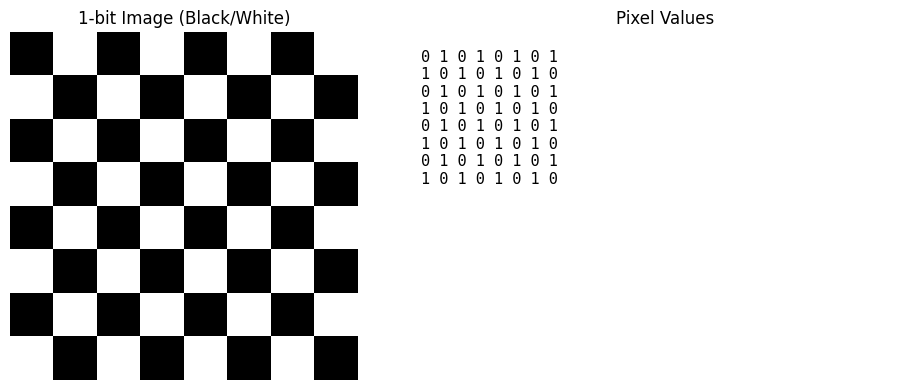

In [4]:
one_bit = np.array([
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0],
], dtype=np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(one_bit, cmap='gray', vmin=0, vmax=1)
ax[0].set_title('1-bit Image (Black/White)')
ax[0].axis('off')

ax[1].axis('off')
ax[1].set_title('Pixel Values')
val_text = '\n'.join([' '.join(map(str, row)) for row in one_bit])
ax[1].text(0, 0.95, val_text, va='top', family='monospace', fontsize=11)

plt.tight_layout()
plt.show()


## Section 2: 2 Bits Give 4 Intensity Levels
With 2 bits, each pixel can represent `2^2 = 4` levels.
A common mapping to 8-bit display values is:
- `00 -> 0` (black)
- `01 -> 85` (dark gray)
- `10 -> 170` (light gray)
- `11 -> 255` (white)


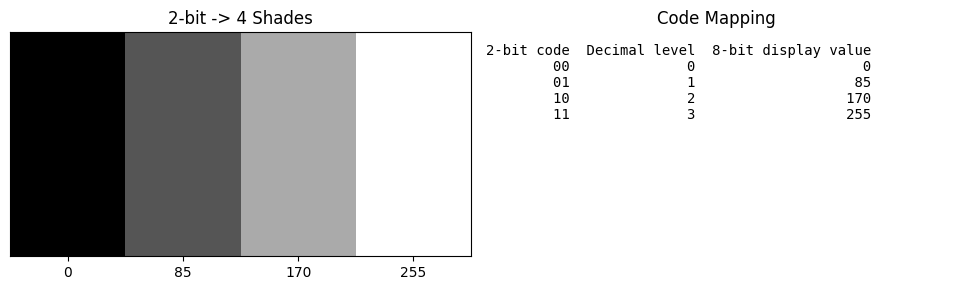

In [5]:
two_bit_levels = np.array([0, 85, 170, 255], dtype=np.uint8)
strip = np.tile(two_bit_levels, (40, 1))

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].imshow(strip, cmap='gray', vmin=0, vmax=255, aspect='auto')
ax[0].set_title('2-bit -> 4 Shades')
ax[0].set_xticks(range(4), ['0', '85', '170', '255'])
ax[0].set_yticks([])

mapping = pd.DataFrame({
    '2-bit code': ['00', '01', '10', '11'],
    'Decimal level': [0, 1, 2, 3],
    '8-bit display value': two_bit_levels,
})
ax[1].axis('off')
ax[1].set_title('Code Mapping')
ax[1].text(0, 0.95, mapping.to_string(index=False), va='top', family='monospace', fontsize=10)

plt.tight_layout()
plt.show()


## Section 3: 4 Bits, 8 Bits, and 16 Bits
As bit depth increases, the number of possible intensity values grows exponentially:
- 4-bit -> `2^4 = 16` levels
- 8-bit -> `2^8 = 256` levels
- 16-bit -> `2^16 = 65,536` levels


,Bit depth,Possible levels (2^bits),Typical use case
0,1,2,Binary masks
1,2,4,Toy examples
2,4,16,Low-depth grayscale
3,8,256,Standard display grayscale / RGB channels
4,16,65536,"Medical imaging source data (CT, MR)"


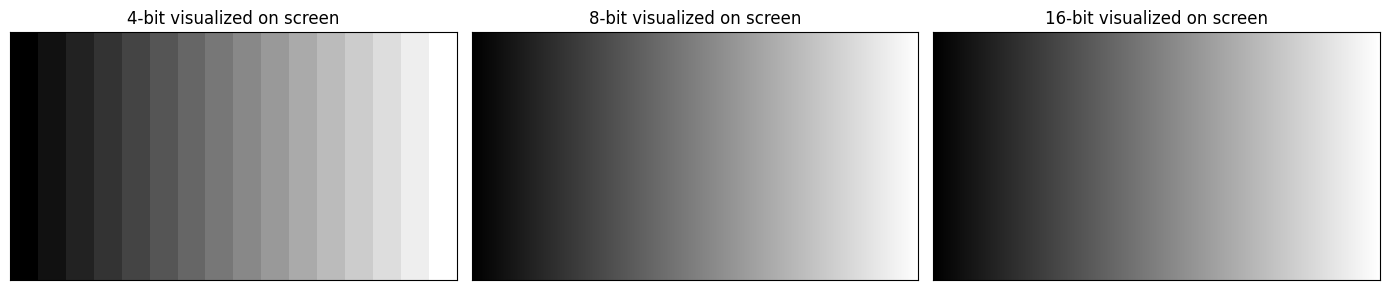

In [6]:
bit_depths = [1, 2, 4, 8, 16]
levels = [2 ** b for b in bit_depths]

summary = pd.DataFrame({
    'Bit depth': bit_depths,
    'Possible levels (2^bits)': levels,
    'Typical use case': [
        'Binary masks',
        'Toy examples',
        'Low-depth grayscale',
        'Standard display grayscale / RGB channels',
        'Medical imaging source data (CT, MR)',
    ]
})
display(summary)

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for ax, bits in zip(axes, [4, 8, 16]):
    vals = np.linspace(0, 255, 2 ** min(bits, 8), dtype=np.uint8)
    band = np.tile(vals, (24, 1))
    ax.imshow(band, cmap='gray', vmin=0, vmax=255, aspect='auto')
    ax.set_title(f'{bits}-bit visualized on screen')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## Section 4: 8-bit Grayscale and Pixel Arrangement
In an 8-bit grayscale image, each pixel is one number from `0` to `255`.
A full image is a 2D matrix of those values.


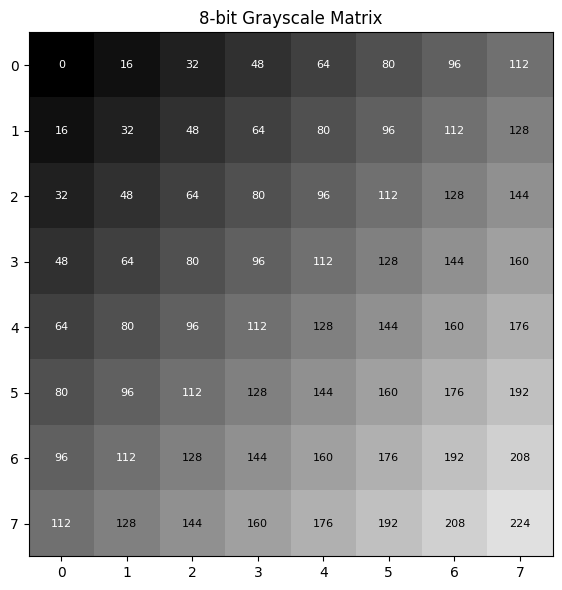

In [7]:
gray_img = np.array([
    [0, 16, 32, 48, 64, 80, 96, 112],
    [16, 32, 48, 64, 80, 96, 112, 128],
    [32, 48, 64, 80, 96, 112, 128, 144],
    [48, 64, 80, 96, 112, 128, 144, 160],
    [64, 80, 96, 112, 128, 144, 160, 176],
    [80, 96, 112, 128, 144, 160, 176, 192],
    [96, 112, 128, 144, 160, 176, 192, 208],
    [112, 128, 144, 160, 176, 192, 208, 224],
], dtype=np.uint8)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
ax.set_title('8-bit Grayscale Matrix')
ax.set_xticks(range(gray_img.shape[1]))
ax.set_yticks(range(gray_img.shape[0]))

for r in range(gray_img.shape[0]):
    for c in range(gray_img.shape[1]):
        value = gray_img[r, c]
        txt_color = 'white' if value < 120 else 'black'
        ax.text(c, r, str(value), ha='center', va='center', fontsize=8, color=txt_color)

plt.tight_layout()
plt.show()


## Section 5: 8-bit Color (RGB)
A color image usually has **3 channels**:
- Red channel: 0-255
- Green channel: 0-255
- Blue channel: 0-255

Each pixel is an `(R, G, B)` triplet.


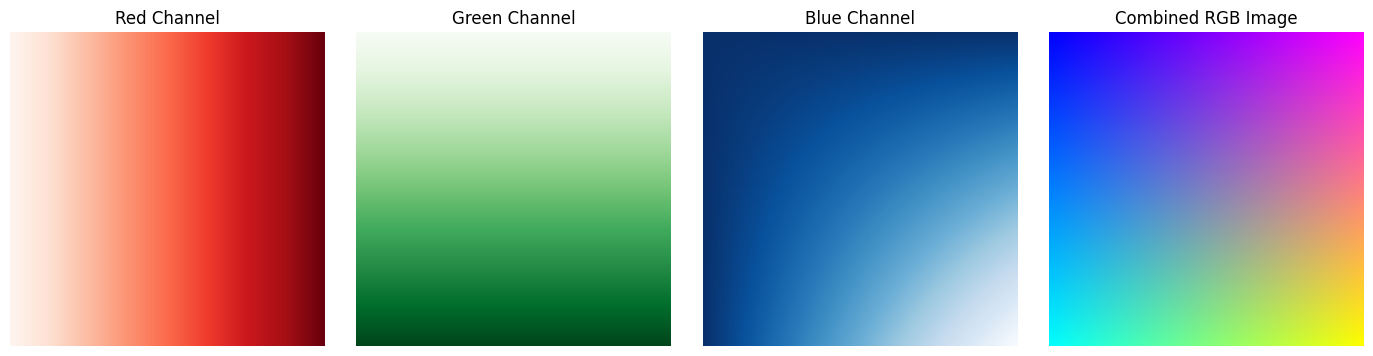

In [8]:
h, w = 128, 128
x = np.linspace(0, 1, w)
y = np.linspace(0, 1, h)
X, Y = np.meshgrid(x, y)

red = (255 * X).astype(np.uint8)
green = (255 * Y).astype(np.uint8)
blue = (255 * (1 - X * Y)).astype(np.uint8)

rgb = np.stack([red, green, blue], axis=-1)

fig, ax = plt.subplots(1, 4, figsize=(14, 3.5))
ax[0].imshow(red, cmap='Reds')
ax[0].set_title('Red Channel')
ax[1].imshow(green, cmap='Greens')
ax[1].set_title('Green Channel')
ax[2].imshow(blue, cmap='Blues')
ax[2].set_title('Blue Channel')
ax[3].imshow(rgb)
ax[3].set_title('Combined RGB Image')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


## Section 6: 16-bit CT Slice in DICOM Format
Medical CT data is often stored with higher dynamic range than normal 8-bit display images.

This section tries to load a sample CT DICOM slice (`CT_small.dcm`) from `pydicom` test data.
If `pydicom` is not installed, run:

`pip install pydicom`


In [9]:
def load_ct_slice_from_dicom(optional_path=None):
    if pydicom is None:
        print('pydicom is not installed. Install with: pip install pydicom')
        return None, None, None

    if optional_path is not None and Path(optional_path).exists():
        dcm_path = str(optional_path)
    else:
        dcm_path = get_testdata_file('CT_small.dcm')

    ds = pydicom.dcmread(dcm_path)
    pixel = ds.pixel_array.astype(np.int16)

    slope = float(getattr(ds, 'RescaleSlope', 1.0))
    intercept = float(getattr(ds, 'RescaleIntercept', 0.0))
    hu = pixel * slope + intercept

    print(f'DICOM path: {dcm_path}')
    print(f'Pixel dtype: {pixel.dtype}, shape: {pixel.shape}')
    print(f'Rescale slope: {slope}, intercept: {intercept}')
    print(f'HU range: min={hu.min():.1f}, max={hu.max():.1f}')

    return ds, pixel, hu

ct_ds, ct_raw, ct_hu = load_ct_slice_from_dicom()

if ct_raw is not None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(ct_raw, cmap='gray')
    ax[0].set_title('Raw CT Pixel Values')
    ax[0].axis('off')

    ax[1].hist(ct_hu.ravel(), bins=80, color='#4c78a8')
    ax[1].set_title('HU Distribution')
    ax[1].set_xlabel('HU')
    ax[1].set_ylabel('Pixel count')

    plt.tight_layout()
    plt.show()


pydicom is not installed. Install with: pip install pydicom


## Section 7: Hounsfield Units and Windowing
Approximate HU anchor points:
- Air: about `-1000`
- Lung tissue: around `-900` to `-500`
- Water: `0`
- Soft tissue: around `30` to `80`
- Bone: `+300` to `+1000` (or higher)

Why windowing?
- CT has many intensity levels (often 16-bit source data).
- Human vision cannot distinguish tens of thousands of gray levels simultaneously.
- Windowing maps a clinically relevant HU range into visible grayscale.


In [10]:
hu_reference = pd.DataFrame([
    {'Material/Tissue': 'Air', 'Approx HU': -1000},
    {'Material/Tissue': 'Lung', 'Approx HU': -800},
    {'Material/Tissue': 'Fat', 'Approx HU': -100},
    {'Material/Tissue': 'Water', 'Approx HU': 0},
    {'Material/Tissue': 'Soft tissue', 'Approx HU': 40},
    {'Material/Tissue': 'Bone (cancellous/cortical)', 'Approx HU': 400},
])
display(hu_reference)


def apply_window(hu_img, level, width):
    low = level - width / 2
    high = level + width / 2
    clipped = np.clip(hu_img, low, high)
    return (clipped - low) / (high - low)

if ct_hu is not None:
    lung = apply_window(ct_hu, level=-600, width=1500)
    bone = apply_window(ct_hu, level=300, width=2000)
    soft = apply_window(ct_hu, level=40, width=400)

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    ax[0].imshow(lung, cmap='gray')
    ax[0].set_title('Lung Window\nL=-600, W=1500')
    ax[1].imshow(soft, cmap='gray')
    ax[1].set_title('Soft Tissue Window\nL=40, W=400')
    ax[2].imshow(bone, cmap='gray')
    ax[2].set_title('Bone Window\nL=300, W=2000')
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

    def interactive_window(level=-600, width=1500):
        img = apply_window(ct_hu, level=level, width=max(width, 1))
        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        plt.title(f'Interactive Window: L={level}, W={width}')
        plt.axis('off')
        plt.show()

    widgets.interact(
        interactive_window,
        level=widgets.IntSlider(value=-600, min=-1000, max=1000, step=50, description='Level'),
        width=widgets.IntSlider(value=1500, min=50, max=3000, step=50, description='Width'),
    )
else:
    print('CT data not loaded, so windowing demo is skipped.')


,Material/Tissue,Approx HU
0,Air,-1000
1,Lung,-800
2,Fat,-100
3,Water,0
4,Soft tissue,40
5,Bone (cancellous/cortical),400


CT data not loaded, so windowing demo is skipped.


## Section 8: Frontal vs Lateral Chest X-ray Classification Setup
We now connect representation concepts to a practical classification task.

**Task:** classify whether a chest X-ray view is **frontal** or **lateral**.

Default source used in this notebook:
1. Hugging Face Open-I dataset: `https://huggingface.co/datasets/ykumards/open-i`

Why this source?
- Open-I provides paired frontal and lateral views in many studies.
- That makes it easier to build a balanced frontal-vs-lateral teaching dataset.

In this section, the notebook will:
1. Download images from Open-I (if local cache is not enough).
2. Build a balanced `frontal` and `lateral` dataset.
3. Prepare a stratified train/test split for the models below.


In [ ]:
def image_from_unknown_payload(payload):
    if payload is None:
        return None

    if isinstance(payload, bytes):
        return Image.open(io.BytesIO(payload)).convert('L')

    if isinstance(payload, str):
        try:
            raw = base64.b64decode(payload)
            return Image.open(io.BytesIO(raw)).convert('L')
        except Exception:
            return None

    if isinstance(payload, dict):
        if 'bytes' in payload and payload['bytes'] is not None:
            return Image.open(io.BytesIO(payload['bytes'])).convert('L')
        if 'path' in payload and payload['path'] and Path(payload['path']).exists():
            return Image.open(payload['path']).convert('L')

    return None


def safe_token(text):
    return ''.join(ch if ch.isalnum() or ch in {'-', '_'} else '_' for ch in str(text))


def resolve_data_root():
    for cand in [Path('../data'), Path('data')]:
        if cand.exists():
            return cand
    fallback = Path('../data')
    fallback.mkdir(parents=True, exist_ok=True)
    return fallback


def ensure_datasets_pkg():
    try:
        import datasets  # noqa: F401
        return True
    except ImportError:
        print('`datasets` not found. Trying one-time install...')
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'datasets'])
            import datasets  # noqa: F401
            print('Installed `datasets` successfully.')
            return True
        except Exception as exc:
            print(f'Could not install `datasets`: {exc}')
            print('Please install manually with: pip install datasets')
            return False


def count_images(folder):
    if not folder.exists():
        return 0
    return len([p for p in folder.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}])


def download_openi_frontal_lateral(max_per_class=500, image_size=96, force_redownload=False):
    data_root = resolve_data_root()
    out_root = data_root / 'cxr_view_small'
    frontal_dir = out_root / 'frontal'
    lateral_dir = out_root / 'lateral'
    frontal_dir.mkdir(parents=True, exist_ok=True)
    lateral_dir.mkdir(parents=True, exist_ok=True)

    if force_redownload:
        for p in list(frontal_dir.glob('*')) + list(lateral_dir.glob('*')):
            if p.is_file():
                p.unlink()

    n_frontal = count_images(frontal_dir)
    n_lateral = count_images(lateral_dir)

    print('Current cached counts:')
    print(f'- frontal: {n_frontal}')
    print(f'- lateral: {n_lateral}')

    if min(n_frontal, n_lateral) >= max_per_class:
        print('Cached dataset is sufficient. Skipping download.')
        return out_root

    if not ensure_datasets_pkg():
        return None

    from datasets import load_dataset

    print('\nDownloading Open-I samples from Hugging Face (streaming)...')
    print('This may take a few minutes depending on internet speed.')

    try:
        stream = load_dataset('ykumards/open-i', split='train', streaming=True)
    except Exception as exc:
        print(f'Could not start Open-I stream: {exc}')
        return None

    # Continue from existing files if present.
    downloaded_frontal = n_frontal
    downloaded_lateral = n_lateral

    for i, ex in enumerate(stream):
        if downloaded_frontal >= max_per_class and downloaded_lateral >= max_per_class:
            break

        uid = safe_token(ex.get('uid', f'row_{i}'))

        if downloaded_frontal < max_per_class:
            f_img = image_from_unknown_payload(ex.get('img_frontal'))
            if f_img is not None:
                out_path = frontal_dir / f'{uid}_{i}_frontal.png'
                f_img.resize((image_size, image_size)).save(out_path)
                downloaded_frontal += 1

        if downloaded_lateral < max_per_class:
            l_img = image_from_unknown_payload(ex.get('img_lateral'))
            if l_img is not None:
                out_path = lateral_dir / f'{uid}_{i}_lateral.png'
                l_img.resize((image_size, image_size)).save(out_path)
                downloaded_lateral += 1

        if (i + 1) % 100 == 0:
            print(f'Processed {i + 1} source rows | frontal={downloaded_frontal} lateral={downloaded_lateral}')

    print('\nDownload step complete:')
    print(f'- frontal: {downloaded_frontal}')
    print(f'- lateral: {downloaded_lateral}')

    if min(downloaded_frontal, downloaded_lateral) == 0:
        print('No usable images found for one or both classes.')
        return None

    return out_root


def build_balanced_manifest(root):
    rows = []
    for label_name, label in [('frontal', 0), ('lateral', 1)]:
        folder = root / label_name
        for p in sorted(folder.iterdir() if folder.exists() else []):
            if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}:
                rows.append({'path': str(p), 'label_name': label_name, 'label': label})

    if not rows:
        return None

    manifest = pd.DataFrame(rows)
    counts = manifest['label_name'].value_counts()
    if len(counts) < 2:
        return None

    per_class = int(counts.min())
    balanced = []
    for label_name in ['frontal', 'lateral']:
        balanced.append(
            manifest[manifest['label_name'] == label_name]
            .sample(n=per_class, random_state=42)
        )

    balanced_manifest = pd.concat(balanced, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
    return balanced_manifest


def load_arrays_from_df(df):
    arrays = []
    labels = []
    for _, row in df.iterrows():
        img = Image.open(row['path']).convert('L')
        arr = np.asarray(img, dtype=np.float32) / 255.0
        arrays.append(arr)
        labels.append(int(row['label']))
    if not arrays:
        return None, None
    return np.stack(arrays), np.array(labels, dtype=np.int64)


TARGET_PER_CLASS = 500  # CPU-friendly target
IMG_SIZE = 96

print('Step 1/3: Download or reuse cached frontal/lateral dataset')
cxr_root = download_openi_frontal_lateral(max_per_class=TARGET_PER_CLASS, image_size=IMG_SIZE, force_redownload=False)

if cxr_root is None:
    print('Dataset download/prep failed. Downstream modeling cells will be skipped.')
    X_train_imgs = y_train_views = X_test_imgs = y_test_views = None
    train_df = test_df = None
else:
    print('\nStep 2/3: Build balanced manifest')
    manifest_df = build_balanced_manifest(cxr_root)

    if manifest_df is None or manifest_df.empty:
        print('Could not build a balanced frontal/lateral manifest.')
        X_train_imgs = y_train_views = X_test_imgs = y_test_views = None
        train_df = test_df = None
    else:
        display(manifest_df.head(8))
        display(manifest_df['label_name'].value_counts().rename('count').to_frame())

        print('\nStep 3/3: Create stratified train/test split')
        train_df, test_df = train_test_split(
            manifest_df,
            test_size=0.25,
            random_state=42,
            stratify=manifest_df['label'],
        )

        X_train_imgs, y_train_views = load_arrays_from_df(train_df)
        X_test_imgs, y_test_views = load_arrays_from_df(test_df)

        print(f'Train images: {len(X_train_imgs)} | Test images: {len(X_test_imgs)}')
        print('Train class balance:')
        print(pd.Series(y_train_views).map({0: 'frontal', 1: 'lateral'}).value_counts())
        print('Test class balance:')
        print(pd.Series(y_test_views).map({0: 'frontal', 1: 'lateral'}).value_counts())


Step 1/3: Download or reuse cached frontal/lateral dataset
Current cached counts:
- frontal: 0
- lateral: 0
`datasets` not found. Trying one-time install...
Installed `datasets` successfully.

This may take a few minutes depending on internet speed.


README.md: 0.00B [00:00, ?B/s]

Processed 100 source rows | frontal=97 lateral=93


## Section 9: Traditional ML Baseline (Logistic Regression)
We flatten each image into a feature vector and train a simple Logistic Regression classifier.
This is a fast baseline for the **frontal vs lateral** task.


In [ ]:
if X_train_imgs is None or X_test_imgs is None:
    print('Skipping ML baseline because dataset preparation did not complete.')
else:
    X_train_flat = X_train_imgs.reshape(len(X_train_imgs), -1)
    X_test_flat = X_test_imgs.reshape(len(X_test_imgs), -1)

    ml_model = LogisticRegression(max_iter=1200, solver='liblinear', random_state=42)
    ml_model.fit(X_train_flat, y_train_views)

    y_pred = ml_model.predict(X_test_flat)
    acc = accuracy_score(y_test_views, y_pred)
    cm = confusion_matrix(y_test_views, y_pred)

    print(f'Logistic Regression accuracy: {acc:.3f}')
    print('\nClassification report:')
    print(classification_report(y_test_views, y_pred, target_names=['frontal', 'lateral']))

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, cmap='Blues')
    ax.set_title('Confusion Matrix (Traditional ML)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1], ['frontal', 'lateral'])
    ax.set_yticks([0, 1], ['frontal', 'lateral'])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()


## Section 10: Deep Learning Baseline (Compact CNN)
Now we train a small CNN directly on pixel grids for the same **frontal vs lateral** split.
Even with a compact architecture, this demonstrates why deep learning is natural for image tasks.


In [ ]:
if X_train_imgs is None or X_test_imgs is None:
    print('Skipping CNN baseline because dataset preparation did not complete.')
else:
    X_train_t = torch.tensor(X_train_imgs[:, None, :, :], dtype=torch.float32)
    X_test_t = torch.tensor(X_test_imgs[:, None, :, :], dtype=torch.float32)
    y_train_t = torch.tensor(y_train_views, dtype=torch.long)
    y_test_t = torch.tensor(y_test_views, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    class TinyViewCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(32 * 24 * 24, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
            )

        def forward(self, x):
            x = self.features(x)
            return self.classifier(x)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TinyViewCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    history = []
    epochs = 4

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == yb).sum().item()
            total += xb.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        model.eval()
        test_correct = 0
        test_total = 0
        all_preds = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                preds = logits.argmax(dim=1)
                test_correct += (preds == yb).sum().item()
                test_total += xb.size(0)
                all_preds.extend(preds.cpu().numpy())

        test_acc = test_correct / test_total
        history.append({'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'test_acc': test_acc})
        print(f'Epoch {epoch:02d} | train_loss={train_loss:.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}')

    hist_df = pd.DataFrame(history)
    display(hist_df)

    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    ax[0].plot(hist_df['epoch'], hist_df['train_loss'], marker='o', color='#e76f51')
    ax[0].set_title('CNN Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(hist_df['epoch'], hist_df['train_acc'], marker='o', label='train_acc', color='#2a9d8f')
    ax[1].plot(hist_df['epoch'], hist_df['test_acc'], marker='o', label='test_acc', color='#577590')
    ax[1].set_title('CNN Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    cm_dl = confusion_matrix(y_test_views, np.array(all_preds))
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm_dl, cmap='Purples')
    ax.set_title('Confusion Matrix (CNN)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1], ['frontal', 'lateral'])
    ax.set_yticks([0, 1], ['frontal', 'lateral'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm_dl[i, j]), ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()


## Section 11: Compare the Baselines
Use these questions as a mini discussion:
1. Which model performed better on your dataset split?
2. Did the classical model already do well, or did CNN add clear value?
3. If performance is poor, is it because of low data volume, label noise, or preprocessing choices?
4. How might mixing PA and AP views inside the frontal class affect results?


## Wrap-up: Key Takeaways
- Images are numerical matrices; bit depth controls how much intensity information each pixel can store.
- 8-bit is common for display, but medical modalities like CT often start with much richer 16-bit ranges.
- Hounsfield Units and windowing convert raw CT values into clinically useful visual views.
- A frontal-vs-lateral classifier is a practical bridge from representation concepts to model building.
- Traditional ML gives a fast baseline; CNNs learn richer spatial patterns directly from pixels.
